In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import balltracking.balltrack as blt
import filters
from scipy.signal import convolve2d
from skimage.exposure import rescale_intensity
from skimage.registration import phase_cross_correlation
from scipy import ndimage
import numpy as np
import fitsio
import matplotlib.pyplot as plt

from pathlib import PurePath, Path
import glob
import multiprocessing
%matplotlib inline

Import some IBIS fits files

In [12]:
ibisdir = Path(os.environ['DATA'], 'Ben', 'IBIS', 'Fe7090')
ibisf = ibisdir.joinpath('ibis.fe7090.lc.int.seq.subsonic.filter.fits')

In [3]:
ibisdata = fitsio.read(str(ibisf))
ibisdata[0,...].shape

(1000, 1000)

Text(0.5, 1.0, 'original frame #4')

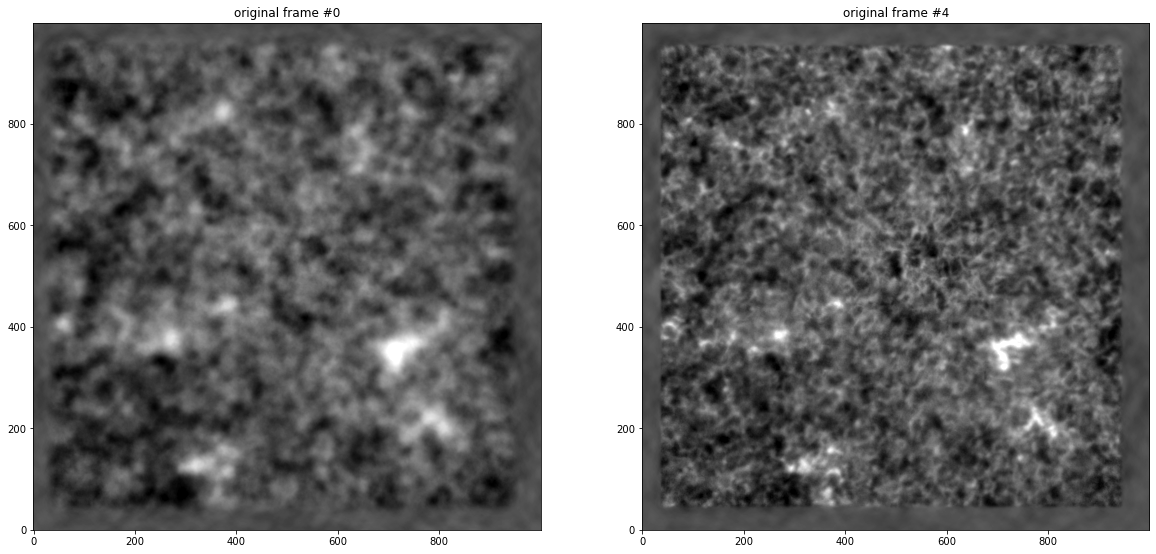

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sample1 = ibisdata[0]
plt.imshow(sample1, origin='lower', vmin=np.percentile(sample1, 0.1), vmax=np.percentile(sample1,99.9), cmap='gray')
plt.title('original frame #0')

plt.subplot(1,2,2)
start_frame = 4
sample2 = ibisdata[start_frame]
plt.imshow(sample2, origin='lower', vmin=np.percentile(sample2, 0.1), vmax=np.percentile(sample2,99.9), cmap='gray')
plt.title(f'original frame #{start_frame}')
          

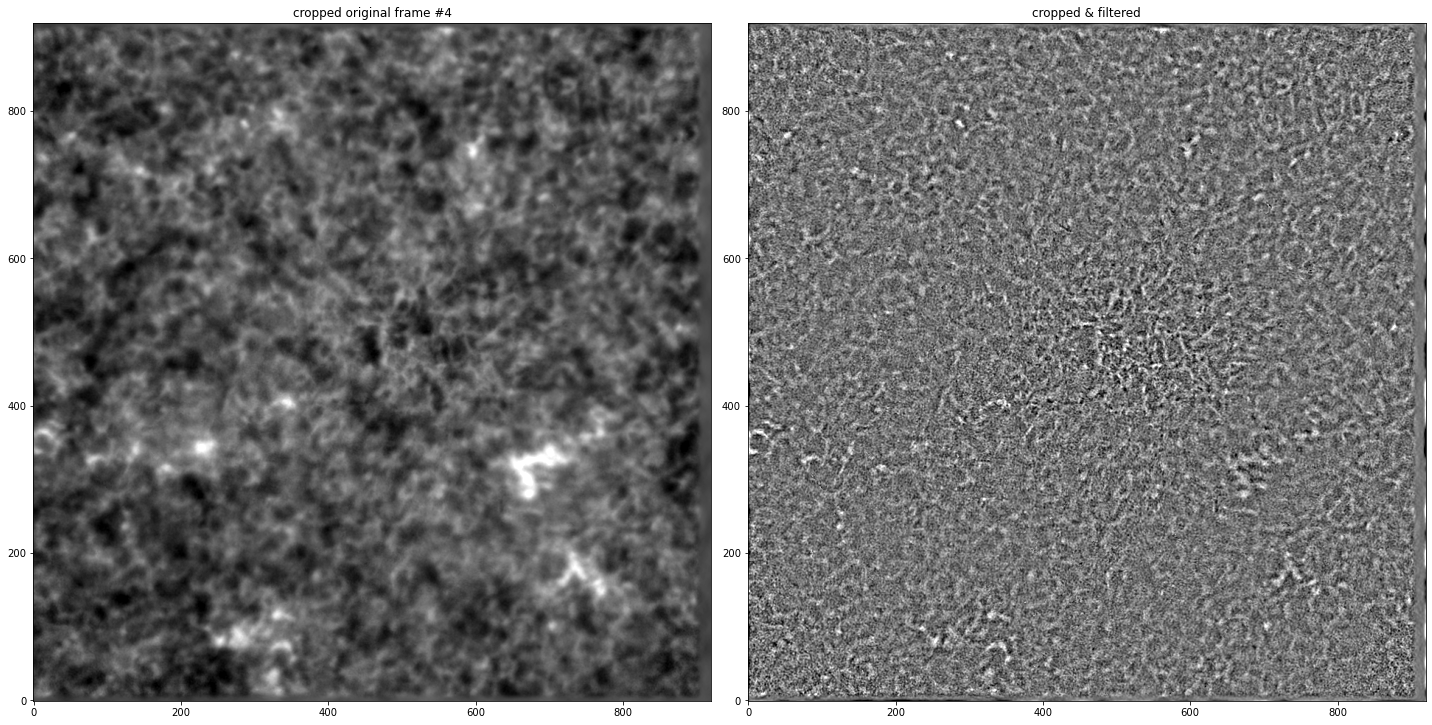

In [44]:
trim = 40
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sample2c = sample2[trim:-trim, trim:-trim]
plt.imshow(sample2c, origin='lower', vmin=np.percentile(sample2c, 0.1), vmax=np.percentile(sample2c,99.9), cmap='gray')
plt.title(f'cropped original frame #{start_frame}')
plt.subplot(1,2,2)
samplef = blt.filter_image(sample2[trim:-trim, trim:-trim], pixel_radius=10)
plt.imshow(samplef, origin='lower', vmin=np.percentile(samplef, 0.1), vmax=np.percentile(samplef,99.9), cmap='gray')
plt.title('cropped & filtered')
plt.tight_layout()

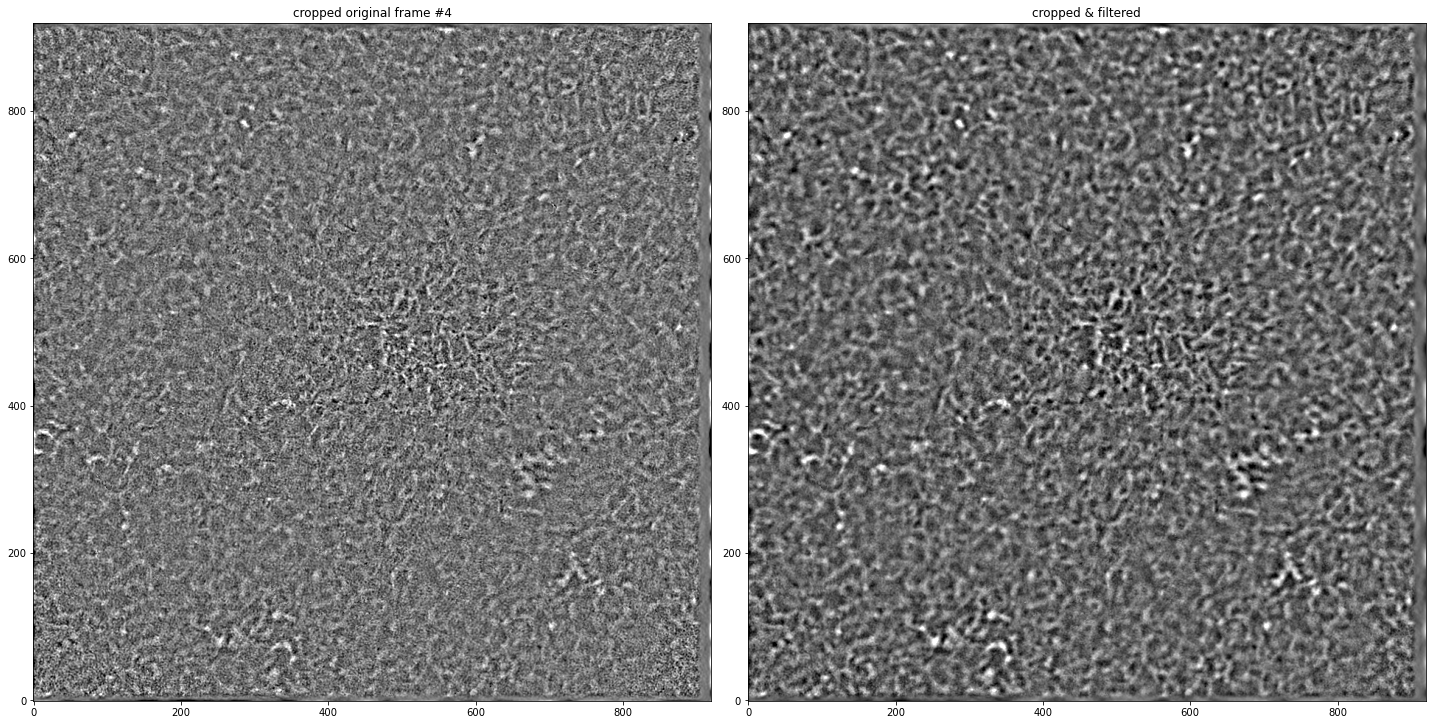

In [53]:
trim = 40
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
samplef = blt.filter_image(sample2[trim:-trim, trim:-trim], pixel_radius=10)
plt.imshow(samplef, origin='lower', vmin=np.percentile(samplef, 0.1), vmax=np.percentile(samplef,99.9), cmap='gray')
plt.title(f'cropped original frame #{start_frame}')
plt.subplot(1,2,2)
samplef2 = blt.filter_image(sample2[trim:-trim, trim:-trim], pixel_radius=20)
plt.imshow(samplef2, origin='lower', vmin=np.percentile(samplef2, 0.1), vmax=np.percentile(samplef2,99.9), cmap='gray')
plt.title('cropped & filtered')
plt.tight_layout()

In [13]:
fitsio.write(ibisdir.joinpath('ibis.fe7090.speckle.cropped.fits'), ibisdata[4:-4, 40:-40, 40:-40])

In [76]:
# Make movie of all filtered images
# dpi = 96
# for i in range(len(fseries)):
#     sample = ibisdata[i, trim:-trim, trim:-trim]
#     samplef = fseries[i]
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(1920/dpi, 1080/dpi), dpi=dpi)
#     axs[0].imshow(sample, origin='lower', vmin=np.percentile(sample, 0.5), vmax=np.percentile(sample,99), cmap='gray')
#     axs[0].set_xlabel('X [px]')
#     axs[0].set_ylabel('Y [px]')
#     axs[0].set_title(f'Original at [0.5 - 99] percentiles - frame #{i}')
#     axs[1].imshow(samplef, origin='lower', vmin=np.percentile(samplef, 0.5), vmax=np.percentile(samplef,99), cmap='gray')
#     axs[1].set_xlabel('X [px]')
#     axs[1].set_ylabel('Y [px]')
#     axs[1].set_title(f'Fourier 1/{radius}-px (Hanning) at [0.5 - 99] percentiles - frame #{i}')
#     plt.tight_layout()
#     plt.savefig(Path(ibisdir, 'Fe7090', 'jpegs', f'ibis.fe7090.{i}.jpeg'), dpi=dpi)
#     plt.close()

In [35]:
trim2 = 80
def get_shift_image(i):
    sample1 = ibisdata[i, trim2:-trim2, trim2:-trim2]
    sample2 = ibisdata[i+1, trim2:-trim2, trim2:-trim2]
    shift, error, diffphase = phase_cross_correlation(sample1, sample2, upsample_factor=100)
    return shift

In [39]:
with multiprocessing.Pool(processes=20) as pool:
    shifts = pool.map(get_shift_image, range(4, 836))
    
shifts1, shifts2 = zip(*shifts)

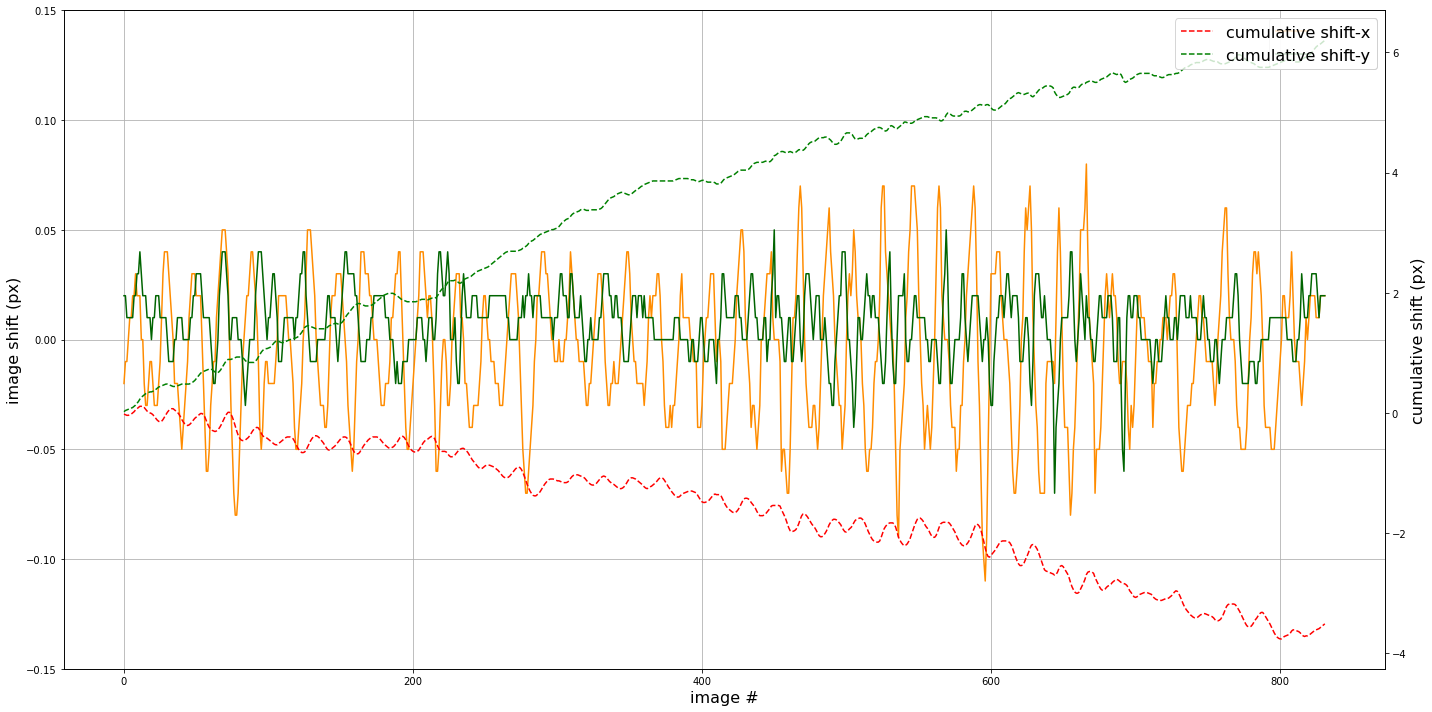

In [40]:
sum1 = np.cumsum(shifts1)
sum2 = np.cumsum(shifts2)
FS = 16
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(shifts2, label='shift-x', color='darkorange')
ax.plot(shifts1, label='shift-y', color='darkgreen')
ax.set_xlabel('image #', fontsize=FS)
ax.set_ylabel('image shift (px)', fontsize=FS)
ax.legend(fontsize=FS)
ax.set_ylim([-0.15, 0.15])
plt.grid()

ax2 = ax.twinx()
ax2.plot(sum2, ls='--', color='red', label='cumulative shift-x')
ax2.plot(sum1, ls='--', color='green', label='cumulative shift-y')
ax2.legend(fontsize=FS, loc='upper right')
ax2.set_ylabel('cumulative shift (px)', fontsize=FS)
plt.tight_layout()
plt.savefig(Path(ibisdir, f'ibis.Fe7090.jitter.png'), facecolor='white')